In [1]:
import salem
import swiss_uhi_utils as suhi
import xarray as xr

from lausanne_greening_scenarios import utils

In [2]:
metrics = ['proportion_of_landscape', 'area_mn', 'shape_index_mn', 'edge_density', 'largest_patch_index']

In [3]:
biophysical_table_filepath = '../data/processed/biophysical-table.csv'
lulc_raster_filepath = '../data/processed/agglom-lulc.tif'
# t_da_filepath = '../data/interim/lst-da.nc'
t_da_filepath = '../data/processed/tair-ucm.nc'

In [4]:
ls, ls_meta = utils.get_reclassif_landscape(
    lulc_raster_filepath, biophysical_table_filepath)

In [5]:
ba = utils.get_buffer_analysis(ls, ls_meta)

In [6]:
zga = utils.get_zonal_grid_analysis(ls, ls_meta)

In [7]:
lulc_da = salem.open_xr_dataset(lulc_raster_filepath)['data']
t_da = suhi.align_ds(xr.open_dataarray(t_da_filepath), lulc_da)

In [8]:
hottest_day_da = t_da.isel(time=t_da.groupby('time').max(dim=['x', 'y']).argmax())
t_arr = hottest_day_da.values

In [9]:
t_arrs = utils.get_zonal_grid_t_arrs(t_arr, zga)

In [13]:
metrics_df = zga.compute_class_metrics_df(metrics=metrics)

In [14]:
utils.get_linear_regression_summary(metrics_df, utils.TREE_CLASS, t_arrs)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      t   R-squared:                       0.474
Model:                            OLS   Adj. R-squared:                  0.463
Method:                 Least Squares   F-statistic:                     43.12
Date:                Mon, 03 Aug 2020   Prob (F-statistic):           1.42e-31
Time:                        08:52:27   Log-Likelihood:                -149.20
No. Observations:                 245   AIC:                             310.4
Df Residuals:                     239   BIC:                             331.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      28.8829      0.301     95.948      0.000      28.290      29.476
proportion_of_landscape    -0.0228      0.003     -8.321      0.000      -0.028      -0.017
area_mn                     0.0834      0.079      1.055      0.293      -0.072       0.239
shape_index_mn             -0.0247      0.269     -0.092      0.927      -0.555       0.505
edge_density                0.0048      0.001      7.960      0.000       0.004       0.006
largest_patch_index         0.0105      0.003      3.253      0.001       0.004       0.017
==============================================================================
Omnibus:                        5.882   Durbin-Watson:                   0.772
Prob(Omnibus):                  0.053   Jarque-Bera (JB):                3.404
Skew:                          -0.025   Prob(JB):                        0.182
Kurtosis:                       2.425   Cond. No.                     1.58e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.58e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pylandstats as pls
import rasterio as rio
import salem
import xarray as xr
from shapely import geometry

from lausanne_greening_scenarios import utils

NODATA_CLASS = 0
TREE_CLASS = 1
IMPERVIOUS_CLASS = 2
HIGH_INTENSITY_CLASS = 3

LABEL_DICT = {
    TREE_CLASS: 'tree',
    IMPERVIOUS_CLASS: 'impervious',
    HIGH_INTENSITY_CLASS: 'high-intensity'
}

BASE_MASK = geometry.Point(6.6327025, 46.5218269)
BUFFER_DISTS = np.arange(1000, 15000, 1000)


def plot_radial_analysis(biophysical_table_filepath,
                         lulc_raster_filepath,
                         t_da_filepath,
                         base_mask=None,
                         buffer_dists=None,
                         buffer_rings=True):
    # process the args
    if base_mask is None:
        base_mask = BASE_MASK
    if buffer_dists is None:
        buffer_dists = BUFFER_DISTS
    # prepare the figure
    figwidth, figheight = plt.rcParams['figure.figsize']
    fig, (ax_left, ax_right) = plt.subplots(2,
                                            1,
                                            figsize=(figwidth, 2 * figheight))

    # left plot: class cover
    # 1. read the data inputs
    biophysical_df = pd.read_csv(biophysical_table_filepath)
    with rio.open(lulc_raster_filepath) as src:
        lulc_arr = src.read(1)
        lulc_res = src.res
        lulc_meta = src.meta
    # 2. reclassify the LULC according to tree cover/impervious surfaces
    reclassif_arr = np.full_like(lulc_arr, NODATA_CLASS)
    for criterion, class_val in zip([
            biophysical_df['shade'] > .75,
        (biophysical_df['green_area'] == 0) & (biophysical_df['shade'] < .75),
            biophysical_df['building_intensity'] > .75
    ], [TREE_CLASS, IMPERVIOUS_CLASS, HIGH_INTENSITY_CLASS]):
        reclassif_arr[np.isin(lulc_arr,
                              biophysical_df[criterion]['lucode'])] = class_val
    # 3. buffer analysis of total area of each reclassified LULC class
    ba = pls.BufferAnalysis(pls.Landscape(reclassif_arr,
                                          res=lulc_res,
                                          lulc_nodata=NODATA_CLASS),
                            base_mask,
                            buffer_dists=buffer_dists,
                            buffer_rings=buffer_rings,
                            base_mask_crs='epsg:4326',
                            landscape_crs=lulc_meta['crs'],
                            landscape_transform=lulc_meta['transform'])
    total_area_df = ba.compute_class_metrics_df(
        metrics=['total_area']).reset_index(level=1)
    # 4. plot it
    for class_val, class_df in total_area_df.groupby(total_area_df.index):
        class_df.plot(x='buffer_dists',
                      y='total_area',
                      style='--o',
                      label=LABEL_DICT[class_val],
                      ax=ax_left)
    ax_left.set_xlabel('dist [m]')
    ax_left.set_ylabel('class area [ha]')
    ax_left.legend()

    # right plot: mean T
    # 1. read the data inputs
    t_da = xr.open_dataarray(t_da_filepath)
    lulc_da = salem.open_xr_dataset(lulc_raster_filepath)['data']
    # 2. align the buffer masks
    buffer_masks_da = utils.align_ds(xr.DataArray(
        ba.masks_arr.astype(np.uint8),
        dims=('buffer_dist', *lulc_da.dims),
        coords={
            'buffer_dist': buffer_dists,
            **lulc_da.coords
        },
        attrs=lulc_da.attrs),
                                     t_da,
                                     interp='nearest')

    # 3. compute the mean buffer temperature
    def compute_mean_buffer_t_da(buffer_mask_da, t_da):
        buffer_mask_cond = buffer_mask_da == 1
        return t_da.groupby('time').apply(lambda t_day_da: t_day_da.where(
            buffer_mask_cond).mean())

    mean_buffer_t_da = buffer_masks_da.groupby('buffer_dist').apply(
        compute_mean_buffer_t_da, args=(t_da, ))
    # 4. plot it
    for date, group_da in mean_buffer_t_da.groupby('time'):
        group_da.plot(ax=ax_right,
                      label=np.datetime_as_string(date, unit='D'),
                      linestyle='--',
                      marker='o')
    ax_right.legend()

    return fig

In [7]:
biophysical_table_filepath = '../data/processed/biophysical-table.csv'
lulc_raster_filepath = '../data/processed/agglom-lulc.tif'
t_da_filepath = '../data/interim/lst-da.nc'

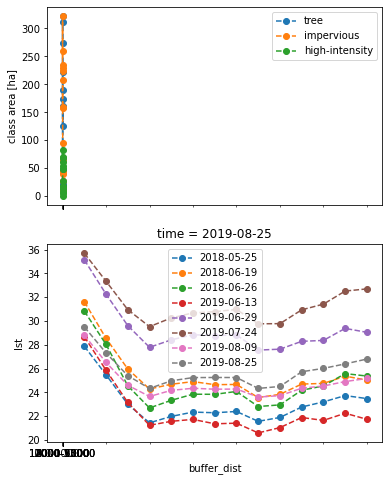

In [8]:
fig = plot_radial_analysis(biophysical_table_filepath, lulc_raster_filepath, t_da_filepath)